In [1]:
!pip install https://github.com/tslearn-team/tslearn/archive/main.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 3.0 MB 1.2 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tslearn: filename=tslearn-0.5.2-cp37-cp37m-linux_x86_64.whl size=732415 sha256=7fdbeb09e0333511841fe79337d270b63cc48ecf4d3d40e285917da7e263ed79
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsexszcl/wheels/71/50/68/28297aeb528fae42ad4b3740425bddbefe0cdef8c8bdb3f08d
Successfully built tslearn


Khai báo thư viện:

In [2]:
import numpy as np
import pandas as pd
import csv
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import date
import concurrent.futures
import random
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

from tslearn.clustering import TimeSeriesKMeans
from numpy import zeros, newaxis

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import classification_report

# Task 1:


1. Choosing 100 stock symbols:

In [3]:
list_symbols = ['AAA', 'AAM', 'ABT', 'ACB', 'ACC', 'ACL', 'ADG', 'ADS',
                'AGM', 'AGR', 'AMD', 'ANV', 'APC', 'APG', 'ASM', 'ASP', 'AST',
                'BBC', 'BCE', 'BCG', 'BCM', 'BFC', 'BHN', 'BIC', 'BID', 'BMC', 'BMI', 'BMP',
                'BRC', 'BSI', 'BTP', 'BTT', 'BVH', 'BWE', 'C32', 'C47', 'CAV', 'CCI', 'CCL', 'CDC',
                'CEE', 'CHP', 'CIG', 'CII', 'CLC', 'CLL', 'CLW', 'CMG', 'CMV', 'CMX', 'CNG',
                'COM', 'CRC', 'CRE', 'CSM', 'CSV', 'CTD', 'CTF', 'CTG', 'CTI', 'CTR', 'CTS', 'CVT',
                'D2D', 'DAG', 'DAH', 'DAT', 'DBC', 'DBD', 'DBT', 'DC4', 'DCL', 'DCM', 'DGC', 'DGW',
                'DHA', 'DHC', 'DHG', 'DHM', 'DIG', 'DLG', 'DMC', 'DPG', 'DPM', 'DPR', 'DQC', 'DRC',
                'DRH', 'DRL', 'DSN', 'DTA', 'EIB', 'ELC', 'EMC', 'EVE', 'EVF', 'EVG', 'FCM', 'FCN', 'FPT']

In [4]:
print(len(list_symbols))

100


2. Collecting the daily stock prices (closing prices):

In [5]:
def scrape_100_stock_symbols(list_symbols):
    with concurrent.futures.ThreadPoolExecutor(max_workers=100) as pool:
      pool.map(scrape_stock_symbols,list_symbols)
    print('Done')

#lấy giá đóng cửa mỗi ngày của từng mã
def scrape_stock_symbols(symbol): 
    min_date = datetime.strptime('01/01/2020', "%d/%m/%Y")
    page_numbers = 1
    f = open(symbol+(".csv"), "w", encoding='UTF8')
    writer = csv.writer(f)
    writer.writerow(['Ngày','Giá đóng cửa'])
    while(1):
      URL = 'https://vcbs.com.vn/vn/Research/StockAnalysis/0?stocksymbol='+symbol+'&page='+str(page_numbers)
      soup = BeautifulSoup(requests.get(URL).text, 'html.parser')
      strRow = soup.findAll('tbody')[0].findAll('tr')
      if (len(strRow) == 0):
        break
      for i in strRow:
        td_list = i.findAll('td')
        date = datetime.strptime(td_list[0].text.strip(), "%d/%m/%Y")
        if(date < min_date):
          f.close()
          return
        price = float(td_list[8].text.strip().replace(',','.'))
        writer.writerow([date.strftime("%d-%m-%Y"),price])
      page_numbers = page_numbers + 1
    f.close()

In [6]:
scrape_100_stock_symbols(list_symbols)

Done


In [8]:
!zip -r /content/sample_data.zip /content/

updating: content/sample_data/ (stored 0%)
updating: content/sample_data/README.md (deflated 42%)
updating: content/sample_data/anscombe.json (deflated 83%)
updating: content/sample_data/mnist_test.csv (deflated 88%)
updating: content/sample_data/california_housing_test.csv (deflated 76%)
updating: content/sample_data/california_housing_train.csv (deflated 79%)
updating: content/sample_data/mnist_train_small.csv (deflated 88%)
  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.05.17/ (stored 0%)
  adding: content/.config/logs/2022.05.17/13.39.01.950417.log (deflated 54%)
  adding: content/.config/logs/2022.05.17/13.39.23.151362.log (deflated 53%)
  adding: content/.config/logs/2022.05.17/13.38.09.439256.log (deflated 91%)
  adding: content/.config/logs/2022.05.17/13.39.22.3

# Task2:

In [10]:
#Lấy ngẫu nhiên 5 mã
five_symbols= random.sample(list_symbols,5)
five_symbols

['ADG', 'DRL', 'CVT', 'CMG', 'DHA']

In [11]:
#Lấy dữ liệu từ files csv của 100 mã
stock_days = {}
stock_data = {}
for i in list_symbols:
  data_symbols = pd.read_csv(i+'.csv')
  stock_days[i] = data_symbols.values[:,0][::-1]
  stock_data[i] = data_symbols.values[:,1][::-1]

In [12]:
stock_data['FPT']

array([58.6, 57.6, 57.0, 58.1, 56.8, 57.6, 57.5, 57.1, 57.0, 57.0, 58.0,
       57.6, 57.4, 55.5, 56.5, 54.7, 52.0, 51.5, 51.8, 52.0, 53.6, 53.3,
       52.6, 53.6, 54.1, 54.3, 54.5, 54.2, 56.0, 55.7, 55.8, 54.7, 52.5,
       54.0, 55.0, 56.0, 55.1, 55.7, 55.9, 55.5, 54.6, 54.0, 50.3, 51.7,
       50.8, 48.1, 48.15, 47.6, 48.5, 48.4, 47.7, 47.7, 44.4, 44.5, 46.0,
       44.2, 43.1, 40.4, 41.1, 42.3, 44.6, 47.5, 47.3, 46.85, 46.85, 46.4,
       46.5, 49.5, 50.1, 50.3, 51.2, 51.3, 49.3, 51.1, 51.0, 51.0, 50.7,
       50.7, 50.8, 50.5, 50.9, 52.9, 53.5, 53.7, 54.0, 54.4, 49.35, 48.7,
       48.0, 48.35, 49.25, 48.9, 49.3, 48.45, 48.45, 48.8, 48.0, 48.0,
       47.95, 48.3, 48.0, 48.65, 48.4, 48.7, 49.35, 48.95, 48.8, 46.0,
       47.0, 46.0, 46.6, 46.35, 46.6, 47.0, 47.0, 47.55, 47.2, 46.8,
       46.85, 46.05, 45.65, 46.2, 46.15, 46.25, 46.8, 47.45, 47.7, 48.35,
       47.8, 48.65, 48.55, 48.6, 48.6, 48.1, 47.4, 47.8, 47.4, 47.75,
       45.9, 43.7, 45.7, 44.55, 45.15, 44.5, 45.9, 46.55,

In [13]:
#tiến hành tiền xử lý dữ liệu bằng TimeSeriesScalerMeanVariance
stock_new_data = {}
for i in list_symbols:
  stock_new_data[i] = TimeSeriesScalerMeanVariance().fit_transform([stock_data[i]])

/usr/local/lib/python3.7/dist-packages/tslearn/preprocessing/preprocessing.py:252: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, allow_nd=True, force_all_finite=False)
/usr/local/lib/python3.7/dist-packages/tslearn/preprocessing/preprocessing.py:286: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, allow_nd=True, force_all_finite=False)
/usr/local/lib/python3.7/dist-packages/tslearn/preprocessing/preprocessing.py:252: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be 

In [14]:
for i in list_symbols:
  stock_new_data[i] = np.asarray(stock_new_data[i]).flatten()

In [15]:
stock_new_data

{'AAA': array([-0.71385518, -0.73243867, -0.88110662, -0.84393964, -0.99260758,
        -0.97402409, -0.9554406 , -0.99260758, -1.02977457, -1.02977457,
        -0.84393964, -0.80677265, -0.82535614, -0.78818915, -0.76960566,
        -0.9554406 , -1.17844252, -1.47577842, -1.36427746, -1.28994348,
        -1.01119108, -0.89969012, -0.9554406 , -0.89969012, -0.86252313,
        -0.88110662, -0.88110662, -0.86252313, -0.91827361, -0.88110662,
        -0.56518723, -0.50943675, -0.84393964, -0.76960566, -0.76960566,
        -0.73243867, -0.86252313, -0.84393964, -0.75102217, -0.75102217,
        -0.76960566, -0.86252313, -1.17844252, -1.234193  , -1.43861143,
        -1.71736384, -1.69878034, -1.43861143, -1.30852698, -1.36427746,
        -1.5315289 , -1.51294541, -1.78798111, -1.69878034, -1.51294541,
        -1.60586287, -1.66161336, -1.84744829, -1.96266595, -1.73966403,
        -1.62444637, -1.43861143, -1.49436191, -1.45719493, -1.40144444,
        -1.49436191, -1.49436191, -1.4386114

In [16]:
#Chuyển kiểu của ngày từ string sang datetime
#Dữ liệu được cập nhật trực tiếp vào biến stock_days
for i in stock_days:
  for j in range(len(stock_days[i])):
    stock_days[i][j] = datetime.strptime(stock_days[i][j], '%d-%m-%Y')

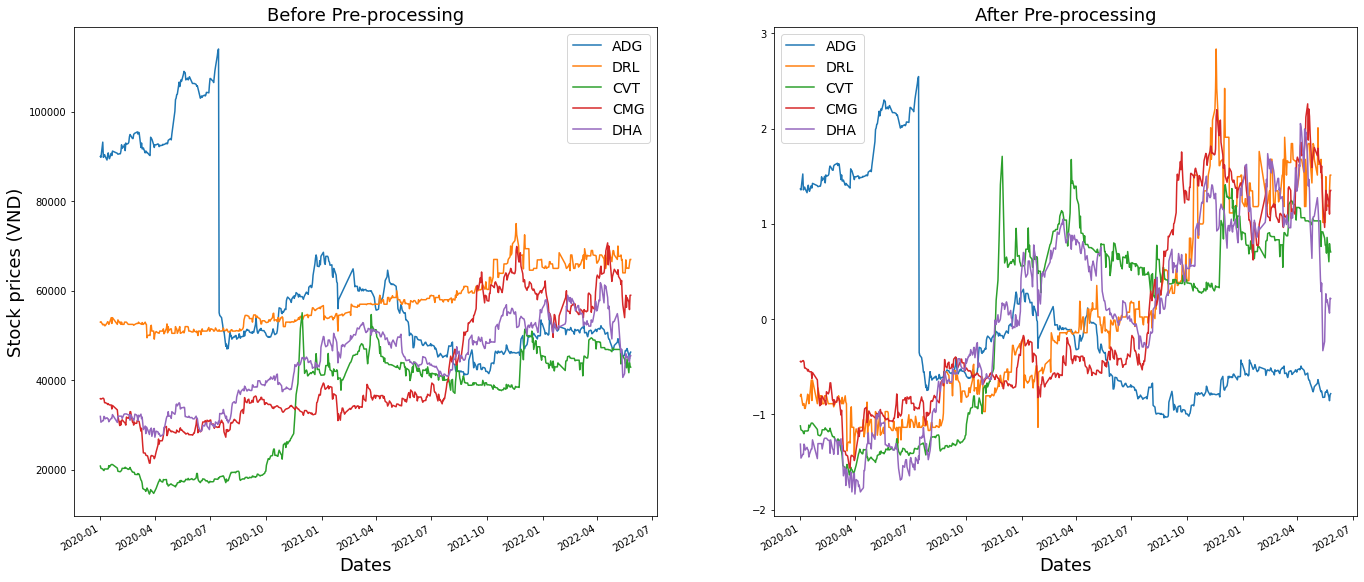

In [17]:
# Plot
fig, axs = plt.subplots(1,2,figsize=[23,10])

for i in range(len(five_symbols)):
  axs[0].plot_date(stock_days[five_symbols[i]], stock_data[five_symbols[i]]*1000, '-' , label=five_symbols[i].format(i=i))
  axs[1].plot_date(stock_days[five_symbols[i]], stock_new_data[five_symbols[i]], '-', label=five_symbols[i].format(i=i))

axs[0].set_title("Before Pre-processing", fontsize=18)
axs[0].legend(loc='best', fontsize = 14)
axs[0].set_ylabel('Stock prices (VND)', fontsize=18)
axs[0].set_xlabel('Dates', fontsize=18)

axs[1].set_title("After Pre-processing", fontsize=18)
axs[1].legend(loc='best', fontsize = 14)
axs[1].set_xlabel('Dates', fontsize=18)

plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
fig.autofmt_xdate()
plt.xlabel('Dates', fontsize=18)
plt.show()

# Task 3:

In [18]:
#tạo dataframe với dữ liệu là giá đóng cửa của 100 mã với cột index là các ngày kể từ 2/1/2020
df_list = []
for i in list_symbols:
  df = pd.DataFrame({i: stock_new_data[i]}, index = stock_days[i])
  df = df.loc[~df.index.duplicated(keep='first')]
  df_list.append(df)
all_df1 = pd.concat(df_list,axis=1)

In [19]:
#Cho giá trị còn thiếu với method time
for col in all_df1:
    all_df1[col] = pd.to_numeric(all_df1[col], errors='coerce')
all_df1 = all_df1.interpolate(method ='time')
'''
Lấy các giá đóng cửa từ dataframe nhưng xoay ngược dataframe lại sao cho mỗi dòng là 
dữ liệu từ 2/1/2020 đến hiện tại của từng mã
'''
reality_data = all_df1.T.values
reality_data = reality_data[:, :, newaxis]

In [ ]:
reality_data

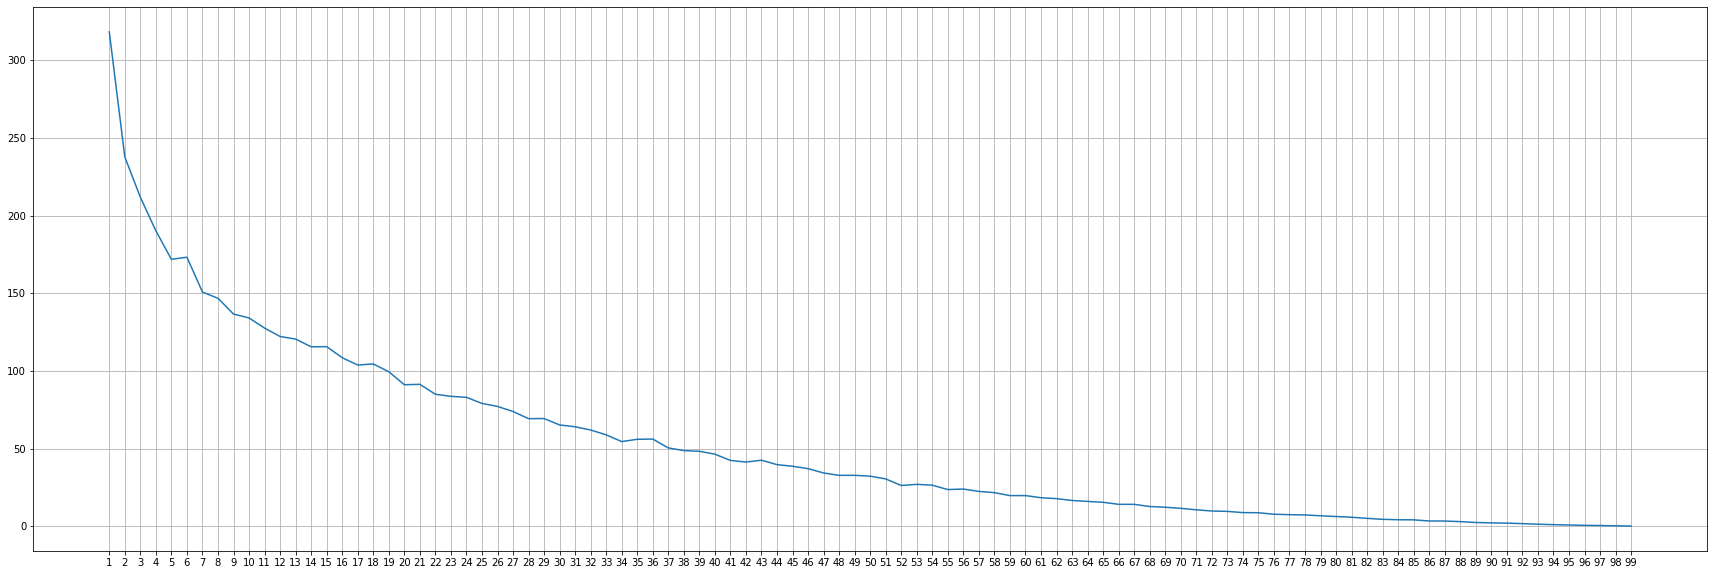

In [20]:
#Plot với dữ liệu là giá đóng cửa của từng mã bằng TimeSeriesKMeans
inertia_list = []
for k in range(1,100):
  km = TimeSeriesKMeans(n_clusters=k)
  km.fit(reality_data)
  inertia_list.append(km.inertia_)
plt.figure(figsize=(30, 10))
plt.plot(range(1,100),inertia_list)
plt.xticks(range(1,100))
plt.grid()
plt.show()

In [22]:
#tạo dataframe với dữ liệu là giá đóng cửa đã qua tiền xử lý của 100 mã với cột index là các ngày kể từ 2/1/2020
df_list = []
for i in list_symbols:
  df = pd.DataFrame({i: stock_new_data[i]}, index = stock_days[i])
  df = df.loc[~df.index.duplicated(keep='first')]
  df_list.append(df)
all_df2 = pd.concat(df_list,axis=1)

#Cho giá trị còn thiếu bằng method time
for col in all_df2:
    all_df2[col] = pd.to_numeric(all_df2[col], errors='coerce')
all_df2 = all_df2.interpolate(method ='time')
data = all_df2.T.values
print(data.shape)
data = TimeSeriesResampler(sz=597).fit_transform(data)
#data = data[:, :, newaxis
print(data.shape)

(100, 597)
(100, 597, 1)


In [23]:
k = 13
se_km = TimeSeriesKMeans(n_clusters=k, verbose=True) 
se_labels = se_km.fit_predict(data)

190.563 --> 125.610 --> 123.603 --> 123.376 --> 123.243 --> 122.788 --> 122.244 --> 121.096 --> 120.489 --> 120.231 --> 120.231 --> 


In [51]:
dba_km = TimeSeriesKMeans(n_clusters=k, n_init=2, metric="dtw", verbose=True, 
                          max_iter_barycenter=10, n_jobs=-1, max_iter=50)
dba_labels = dba_km.fit_predict(data)

Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4

14.518 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.359 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.295 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.241 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.219 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.219 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4

13.552 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.537 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.403 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


8.403 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    1.8s finished


In [52]:
sdtw_km = TimeSeriesKMeans(n_clusters=k, metric="softdtw", 
      metric_params={"gamma": .01}, verbose=True, max_iter_barycenter=10, 
      n_jobs=-1, max_iter=50)
sdtw_labels = sdtw_km.fit_predict(data)

360.415 --> 110.420 --> 101.734 --> 94.147 --> 94.234 --> 94.159 --> 94.159 --> 94.132 --> 94.119 --> 94.074 --> 94.071 --> 94.037 --> 94.035 --> 94.010 --> 94.015 --> 93.956 --> 93.756 --> 93.625 --> 93.631 --> 93.558 --> 93.549 --> 93.514 --> 93.514 --> 


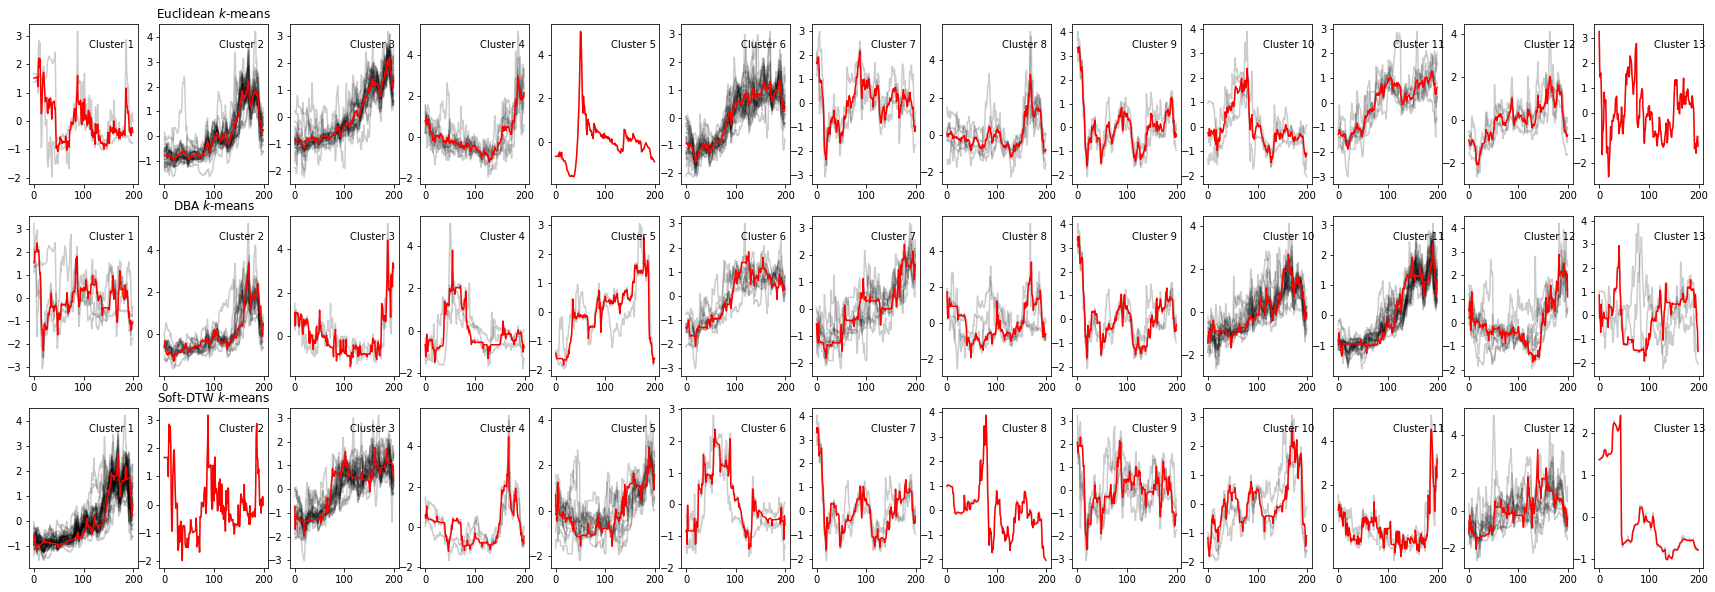

In [54]:
plt.figure(figsize=(30, 10))
for yi in range(k):
    plt.subplot(3, k, 1 + yi)
    for xx in data[se_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(se_km.cluster_centers_[yi].ravel(), "r-")
  
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

for yi in range(k):
    plt.subplot(3, k, 1 + k + yi)
    for xx in data[dba_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

for yi in range(k):
    plt.subplot(3, k, 1 + k * 2 + yi)
    for xx in data[sdtw_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

fig.tight_layout()
plt.show()

# Task 4:

In [14]:
#Chọn 1 mã 
one_symbol= random.choice(list_symbols)
one_symbol

'DCM'

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(stock_data[one_symbol].reshape(-1, 1))
train_data = []
train_day = []

first_day_2022 = datetime.strptime('01/01/2022', "%d/%m/%Y")
for i,j in zip(stock_days[one_symbol], dataset): #stock_new_data[one_symbol]):
  if(i > first_day_2022):
    break
  train_data.append(j)
  train_day.append(i)

In [18]:
train_data = np.array(train_data)
train_data

array([[2.82669138e-02],
       [2.59499537e-02],
       [2.34012975e-02],
       [2.08526413e-02],
       [1.66821131e-02],
       [1.55236330e-02],
       [1.59870250e-02],
       [1.64504171e-02],
       [1.64504171e-02],
       [1.57553290e-02],
       [1.57553290e-02],
       [1.45968489e-02],
       [1.43651529e-02],
       [1.52919370e-02],
       [1.83039852e-02],
       [1.52919370e-02],
       [1.43651529e-02],
       [9.03614458e-03],
       [1.06580167e-02],
       [9.26784059e-03],
       [9.49953661e-03],
       [1.18164968e-02],
       [1.18164968e-02],
       [1.48285449e-02],
       [1.78405931e-02],
       [1.83039852e-02],
       [2.06209453e-02],
       [1.89990732e-02],
       [2.03892493e-02],
       [2.06209453e-02],
       [2.27062095e-02],
       [2.15477294e-02],
       [1.83039852e-02],
       [1.85356812e-02],
       [1.85356812e-02],
       [1.92307692e-02],
       [1.83039852e-02],
       [1.69138091e-02],
       [1.71455051e-02],
       [2.24745134e-02],


In [19]:
x_train = []
y_train = []

for i in range(100, len(train_data)):
  x_train.append(train_data[i-100: i])
  y_train.append(train_data[i])

In [20]:
x_train, y_train = np.array(x_train) , np.array(y_train)

In [21]:
#x_train = x_train[:, :, newaxis]
x_train.shape

(402, 100, 1)

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error' )

In [24]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

402/402 [==============================] - 3s 8ms/step - loss: 0.0012


In [25]:
test_data =  dataset[len(train_data) - 100 :]  #stock_new_data[one_symbol][len(train_data) - 100 :]
test_day = stock_days[one_symbol][len(train_data):]
x_test = []
y_test = dataset[len(train_data):]  #stock_new_data[one_symbol][len(train_data):]
for i in range(100, len(test_data)):
  x_test.append(test_data[i-100:i])

In [26]:
x_test = np.array(x_test)
#x_test = x_test[:, :, newaxis]
x_test.shape

(94, 100, 1)

In [43]:
prediction = model.predict(x_test)

In [42]:
prediction = scaler.inverse_transform(prediction)

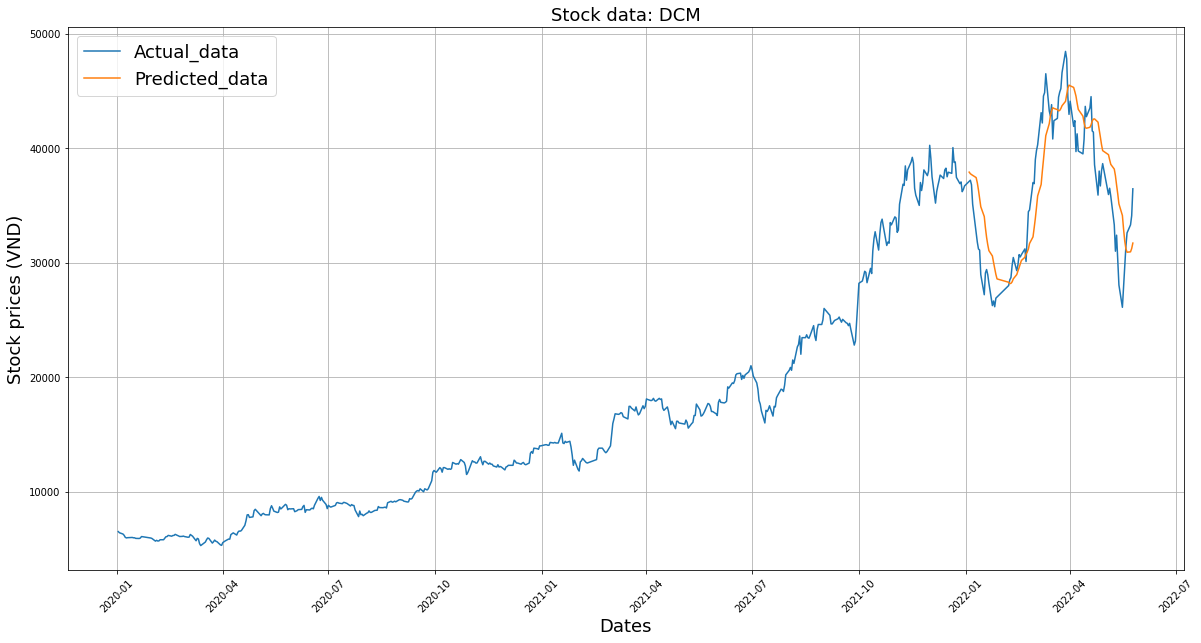

In [40]:
plt.figure(figsize=(20, 10))
plt.plot_date(stock_days[one_symbol] , stock_data[one_symbol] *1000 ,'-', label= 'Actual_data')
plt.plot_date(test_day , prediction *1000,'-', label= 'Predicted_data')
plt.legend(loc='best', fontsize=18)
plt.xticks(rotation = 45)
plt.grid()
plt.title('Stock data: ' + one_symbol, fontsize=18)
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Stock prices (VND)', fontsize=18)
plt.show()